### cifar10 with cnn feat pytorch

Device: cuda
Epoch 1/10 - Train Loss: 2.1109 - Train Acc: 0.1962 - Test Acc: 0.3099
Epoch 2/10 - Train Loss: 1.8588 - Train Acc: 0.3022 - Test Acc: 0.3836
Epoch 3/10 - Train Loss: 1.7069 - Train Acc: 0.3611 - Test Acc: 0.4034
Epoch 4/10 - Train Loss: 1.5874 - Train Acc: 0.4108 - Test Acc: 0.4608
Epoch 5/10 - Train Loss: 1.4912 - Train Acc: 0.4521 - Test Acc: 0.5167
Epoch 6/10 - Train Loss: 1.4263 - Train Acc: 0.4800 - Test Acc: 0.5491
Epoch 7/10 - Train Loss: 1.3637 - Train Acc: 0.5078 - Test Acc: 0.5548
Epoch 8/10 - Train Loss: 1.3199 - Train Acc: 0.5245 - Test Acc: 0.5529
Epoch 9/10 - Train Loss: 1.2748 - Train Acc: 0.5435 - Test Acc: 0.5921
Epoch 10/10 - Train Loss: 1.2444 - Train Acc: 0.5571 - Test Acc: 0.5959
Test Accuracy: 0.5959


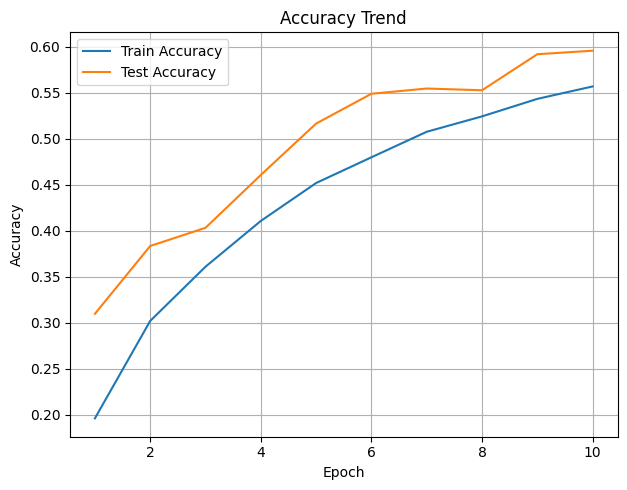

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset

# 🌟 1) GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 🌟 2) 데이터 전처리 (ImageDataGenerator와 유사)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, shear=0.2, translate=(0.2,0.2)),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

# 🌟 3) 데이터셋 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 🌟 4) DataLoader 준비
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  

# 🌟 5) CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.25)
       
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.25)
       
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.25)
       
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.drop4 = nn.Dropout(0.25)
       
        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.drop5 = nn.Dropout(0.25)
       
        self.fc1 = nn.Linear(256*1*1, 128)  # 32x32 -> 1x1
        self.drop_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.drop1(x)
       
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.drop2(x)
       
        x = F.relu(self.conv5(x))
        x = self.pool3(x)
        x = self.drop3(x)
       
        x = F.relu(self.conv6(x))
        x = self.pool4(x)
        x = self.drop4(x)
       
        x = F.relu(self.conv7(x))
        x = self.pool5(x)
        x = self.drop5(x)
       
        x = x.view(-1, 256*1*1)
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)
        return x

model = CNNModel().to(device)  

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🌟 7) 학습 + 평가 (train & test accuracy 기록)
epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    # ---- 학습 ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
       
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
   
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- 검증 ----
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = correct / total
    test_accuracies.append(test_acc)

    # ---- 결과 출력 ----
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f} - "
          f"Train Acc: {train_acc:.4f} - "
          f"Test Acc: {test_acc:.4f}")
# 🌟 8) 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print("Test Accuracy:", test_acc)
# 9) 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy 그래프
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()